# Predict expression modulation targets

Algorithms like Optgene can predict gene knockout targets, but another possibility for optimizing hemoglobin production is up- or downregulation of genes. A function for this is the Flux Scanning based on Enforced Objective Flux (FSEOF) from the Computer Aided Metabolic Engineering & Optimization (CAMEO) package. FSEOF searches for genes for up- or down-regulation by first enforcing the flux of a desired reaction under the objective of maximizing biomass production (Choi et al 2010). The function then indentifies the metabolic fluxes, which increased or decreased when the desired reaction was forced to increase (Choi et al 2010). 

In [8]:
from cobra.io import read_sbml_model
from cobra import Reaction, Metabolite
from cameo import models
from cameo.visualization.plotting.with_plotly import PlotlyPlotter
import numpy as np
from cameo.strain_design.deterministic.flux_variability_based import FSEOF

Load model:

In [9]:
model = read_sbml_model('model_standard_yeast.xml')
model.add_boundary(model.metabolites.pheme_m, type='demand')

Reaction identifier,DM_pheme_m
Name,Protoheme C34H30FeN4O4 demand
Memory address,0x01e1d0683c40
Stoichiometry,pheme_m --> Protoheme C34H30FeN4O4 -->
GPR,
Lower bound,0
Upper bound,1000.0


## Flux Scanning based on Enforced Objective Flux

Define and run the FSEOF analysis. As specified in fseof.run, the target for optimization is here the "FCLTm" reaction, which is the last reaction in the heme pathway. By default the flux of the target reaction is maximized to 90% of its theoretical maximum. Furthermore, as described above the primary objective is the model.objective by default (here, biomass).

In [10]:
fseof = FSEOF(model)

In [11]:
result = fseof.run(target=model.reactions.FCLTm)

The results are saved in a dataframe:

In [12]:
df = result.data_frame

In [13]:
df

,1,2,3,4,5,6,7,8,9,10
ACALDtm,-0.893097,-0.726347,-0.595436,-0.464524,-0.333613,-0.202701,-0.347954,-1.467670,-2.559757,-3.690653
AGTi,0.410217,0.571932,0.721701,0.871470,1.021239,1.171008,1.326142,1.487956,1.649770,1.811584
ALASm,0.396136,0.792272,1.188408,1.584544,1.980680,2.376816,2.772953,3.169089,3.565225,3.961361
ALATA_L,-0.534190,-0.685505,-0.824875,-0.964245,-1.103615,-1.242985,-1.387205,-1.535362,-1.683519,-1.831676
ACONT,0.591867,0.793064,0.922585,1.052107,1.181629,1.311150,1.461736,1.593224,1.724712,1.856199
...,...,...,...,...,...,...,...,...,...,...
UGLT,-0.453063,-0.415059,-0.377055,-0.339051,-0.301048,-0.263044,-0.223156,-0.173246,-0.123336,-0.073426
UPP3S,0.049517,0.099034,0.148551,0.198068,0.247585,0.297102,0.346619,0.396136,0.445653,0.495170
UPPDC1,0.049517,0.099034,0.148551,0.198068,0.247585,0.297102,0.346619,0.396136,0.445653,0.495170
PYK,17.786676,17.871020,17.943417,18.015815,18.088213,18.160611,18.245585,18.375597,18.505610,18.635623


The results above show **85** reactions which increase or decrease, when the flux of the heme pathway is forced to increase, and are thus targets for up- or down-regulation. Below the reaction fluxes 

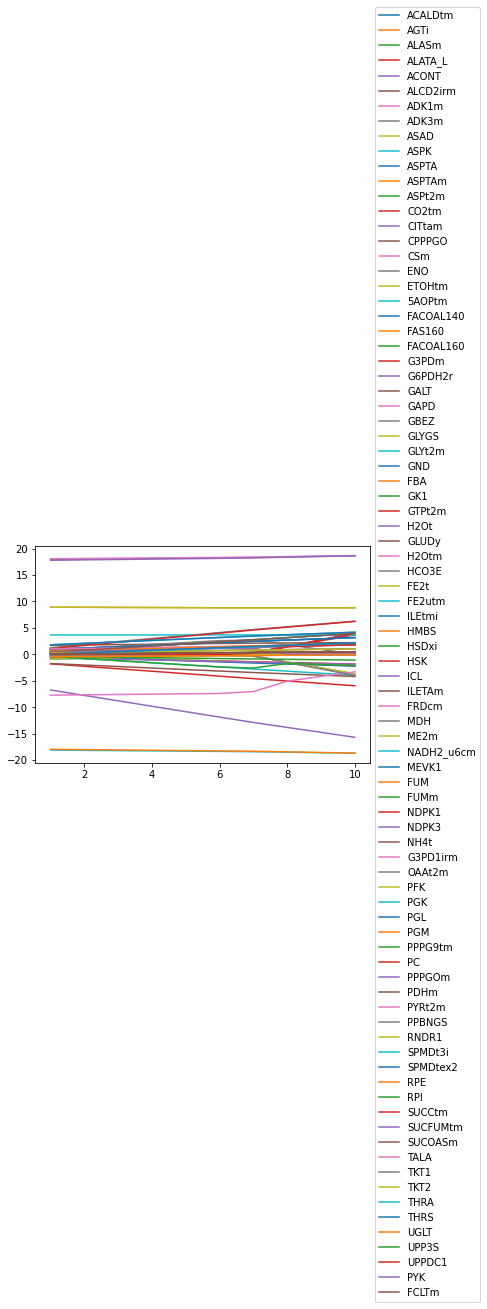

In [14]:
# plot from here: https://biosustain.github.io/cell-factory-design-course/10-Predict-gene-expression-modulation-targets/
from matplotlib import pyplot as plt
result.data_frame.T.plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

To get a better overview of the results, two columns are added to the dataframe: Change and Percent Change. The Change describes the change (positive or negative) from the first calculated flux to the last (at 90% of theoretical max for desired product). The Percent Change describes the change in percentage relative to the beginning value, as calculated by:

$\frac{flux_{end} - flux_{start}}{flux_{start}} * 100$

In [15]:
change = []
for i in range(len(df)):
    change.append(df.iloc[i,9]-df.iloc[i,0])
    
df['Change']=change

In [16]:
percent_change = []
for i in range(len(df)):
    if df.iloc[i,0] != 0:
        percent_change.append(((df.iloc[i,9]-df.iloc[i,0])/df.iloc[i,0])*100)
    else:
        percent_change.append(np.nan)

df['Percent_change']=percent_change

The reactions can then be sorted based on Percent Change to see the reactions with the highest relative change and thereby most effective targets:

In [18]:
df_sorted = df.reindex(df.Percent_change.abs().sort_values(ascending=False).index)
df_sorted

,1,2,3,4,5,6,7,8,9,10,Change,Percent_change
HSK,0.102005,0.326688,0.563318,0.799947,1.036577,1.273207,1.503989,1.725522,1.947056,2.168590,2.066585,2025.964414
THRS,0.102005,0.326688,0.563318,0.799947,1.036577,1.273207,1.503989,1.725522,1.947056,2.168590,2.066585,2025.964414
HSDxi,0.117488,0.340873,0.576203,0.811534,1.046865,1.282196,1.511615,1.731443,1.951271,2.171099,2.053611,1747.932555
ASPK,0.117488,0.340873,0.576203,0.811534,1.046865,1.282196,1.511615,1.731443,1.951271,2.171099,2.053611,1747.932555
ASAD,-0.117488,-0.340873,-0.576203,-0.811534,-1.046865,-1.282196,-1.511615,-1.731443,-1.951271,-2.171099,-2.053611,1747.932555
...,...,...,...,...,...,...,...,...,...,...,...,...
FRDcm,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027628,0.016448,0.016448,NaN
MDH,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.283839,-1.517390,-2.750942,-3.984493,-3.984493,NaN
G3PD1irm,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027628,0.016448,0.016448,NaN
SUCCtm,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.198233,1.450930,1.677398,1.828032,1.828032,NaN


The reaction name for the top 10 reactions with the highest relative change is given below:

In [19]:
for i in range(10):
    print(model.reactions.get_by_id(df_sorted.index.values[i]).id, model.reactions.get_by_id(df_sorted.index.values[i]).name)

HSK Homoserine kinase
THRS Threonine synthase
HSDxi Homoserine dehydrogenase  NADH   irreversible
ASPK Aspartate kinase
ASAD Aspartate-semialdehyde dehydrogenase
NDPK1 Nucleoside-diphosphate kinase (ATP:GDP)
5AOPtm 5 Aminolevulinate mitochondrial transport
SUCOASm Succinate  CoA ligase  ADP forming 
ALASm 5 aminolevulinate synthase
GLYt2m Glycine mitochondrial transport via proton symport


* The top 5 reactions are convert L-aspartate to Threonine. Threonine can then be converted to glycine, which is the precursor in the heme pathway. So it makes sense that these are up-regulated to produce more heme. 
* ALASm is the first reaction in the heme synthesis pathway: it combines glycine with succinyl-CoA to make aminolevulinate. 
* 5AOPtm is the transporter, which transports aminolevulinate between the mitochondrion (where it is made) and the cytoplasm (where the pathway continues).
* SUCOASm makes more succinyl-CoA, which is needed in the ALASm reaction
* GLYt2m transports glycine between the mitochondrion and cytoplasm, which makes sense since it is needed for synthesis inside the mitocondrion by ALASm

Don't know what NDPK1 is used for (other than just making more GTP)

In [27]:
# Make dictionary of the reaction ID and flux of the top 10 reactions that are upregulated:
Upreg_fluxes = dict(zip(df_sorted.index.values[0:10], df_sorted.iloc[0:10,10]))

In [ ]:
import escher

An Escher submap was created of the heme biosynthesis (using the guide in here: https://escher.readthedocs.io/en/latest/escher-python.html) - it includes the synthesis of glycine, which an early precursor of heme and goes all the way to protoheme. It was done by loading our SBML model into the Escher Builder like this: escher.Builder(model = model). Then all relevant reactions were manually added to the submap by clicking 'Edit' -> 'Add reaction mode'. It will suggest the following reactions based on the product.

After all the reactions were added, I downloaded the map ('Map' -> 'Save map JSON') as the file IMM904.Hemebiosynthesis.json.

Using the map created above, we can load our model and the map. Then we can display the reactions that are should be modulated based on the FSEOF analysis. Here, the flux data is loaded in with the dictionary. Note, it did not work at first, but you can adjust what values get colored in the 'View'->'Settings' and then scroll down.

In [23]:
escher.Builder(model = model,
    map_json='iMM904.Hemebiosynthesis.json',
               reaction_data=Upreg_fluxes)

Builder(reaction_data={'HSK': 2.066585, 'THRS': 2.066585, 'HSDxi': 2.053611, 'ASPK': 2.053611, 'ASAD': -2.0536…

The top 10 reactions is then plotted:

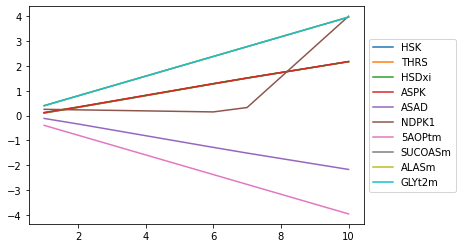

In [24]:
df_sorted.iloc[0:10,:10].T.plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [25]:
with model:
    model.reactions.get_by_id("HSK").lower_bound = 2.168590
    model.reactions.get_by_id("HSK").lower_bound = 2.168590

    #niko says change upper and lower bound to the things we got in the matrix -> simulated up-regulated

In [26]:
model.metabolites.get_by_id('nadh_c')

Metabolite identifier,nadh_c
Name,Nicotinamide adenine dinucleotide - reduced
Memory address,0x01e1d121fcd0
Formula,C21H27N7O14P2
Compartment,c
In 41 reaction(s),"NADH2_u6cm, IMPD, 2HBO, IPMD, ALDD22x, NABTNO, SBTD_D2, ALCD24xi, XYLTD_D, HPROa, SBTD_L, MTHFD2i, ALCD26xi, LNS14DMx, HSDxi, G3PD1ir, ALCD2x_copy1, PGCD, LCADi, AASAD2, G5SD2, C3STDH2, HISTD,..."


### Sources:

Choi, H. S., Lee, S. Y., Kim, T. Y., & Woo, H. M. (2010). In silico identification of gene amplification targets for improvement of lycopene production. Applied and Environmental Microbiology, 76(10), 3097–3105. https://doi.org/10.1128/AEM.00115-10


Other sources, not cited:

https://cameo.bio/06-predict-gene-modulation-targets.html

https://bmcsystbiol.biomedcentral.com/articles/10.1186/1752-0509-6-106/figures/2

Park, J. M., Park, H. M., Kim, W. J., Kim, H. U., Kim, T. Y., & Lee, S. Y. (2012). Flux variability scanning based on enforced objective flux for identifying gene amplification targets. BMC Systems Biology, 6. https://doi.org/10.1186/1752-0509-6-106

## Differential flux variability analysis

Compares flux ranges of a reference model to a set of models that have been parametrized to lie on a grid of evenly spaced points in the *n*-dimensional production envelope (*n* being the number of reaction bounds to be varied).

In [ ]:
from cameo.flux_analysis.analysis import phenotypic_phase_plane
from cameo.strain_design.deterministic import DifferentialFVA
plotter = PlotlyPlotter()

In [ ]:
production_envelope = phenotypic_phase_plane(model, 
                                             variables=[model.reactions.BIOMASS_SC5_notrace],
                                             objective=model.metabolites.pheme_m)
production_envelope.plot(plotter, height=400)

In [ ]:
model.reactions.EX_o2_e.lower_bound = 0
reference_model = model.copy()
biomass_rxn = reference_model.reactions.BIOMASS_SC5_notrace
biomass_rxn.lower_bound = 0.
target = reference_model.metabolites.pheme_m

In [ ]:
diffFVA = DifferentialFVA(design_space_model=model,
                          reference_model=reference_model,
                          objective=target,
                          variables=[biomass_rxn],
                          normalize_ranges_by=biomass_rxn,
                          points=10)

In [ ]:
result = diffFVA.run(surface_only=True)

In [ ]:
result.solutions

In [ ]:
result.plot(plotter, 5, variables=['FBP', 'G6PDH2r', 'PGL', 'PGK'])